In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split as tts
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier, early_stopping




ModuleNotFoundError: No module named 'catboost'

In [86]:
pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 3.5 MB/s eta 0:00:00


In [94]:
from catboost import CatBoostClassifier

# Base Class for all classifier Models

In [28]:


class ClassificationModel:
  def __init__(self, data, label, test_size = 0.25, random_state = 43):
    data.dropna(inplace=True)
    self.data  = data
    self.X = self.data.drop([label], axis = 1)
    self.X_train = None
    self.X_test = None
    self.Y = self.data[label]
    self.Y_train = None
    self.Y_test = None
    self.Encoder = LabelEncoder()
    self.test_size = test_size
    self.random_state = random_state
    self.model = None
    self.best_model = self.model


  #spli the data into test and train
  def split_data(self):
    self.X_train, self.X_test, self.Y_train, self.Y_test = tts(self.X,self.Y, test_size = self.test_size, random_state = self.random_state, stratify = self.Y)


  def Encode_data(self):
    self.X_train = pd.get_dummies(self.X_train, drop_first=True)
    self.X_test = pd.get_dummies(self.X_test, drop_first=True)
    self.Y_train = self.Encoder.fit_transform(self.Y_train)
    self.Y_test = self.Encoder.transform(self.Y_test)

  def train(self):
    pass


  #results after testing the model on test data
  def print_results(self):
    if(self.model!=None):
      test_predictions = self.best_model.predict(self.X_test)
      accuracy = accuracy_score(self.Y_test,test_predictions)*100
      precision = precision_score(self.Y_test, test_predictions, average='micro')*100
      cm = confusion_matrix(self.Y_test, test_predictions)
      return [cm,accuracy,precision]


  def predict(self, X):
    if(self.model!=None):
       X = pd.get_dummies(X, drop_first=True)
       predictions = self.best_model.predict(X)
       return predictions





# Model Classes Built for Different Algorithms

In [99]:

class Treeclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = DecisionTreeClassifier()


  def train(self):
   self.split_data()
   self.Encode_data()
   #hyperparameter tuning
   param_dist = {
    'max_depth': range(2,int(len(self.X_train.columns)/2)),
    'min_samples_split': range(2,10),
    'criterion': ['gini', 'entropy','log_loss']
   }

   Random_search = RandomizedSearchCV(self.model, param_dist, n_iter=25, cv = 10, scoring = 'accuracy')
   Random_search.fit(self.X_train, self.Y_train)
   self.best_model = Random_search.best_estimator_




class RFclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = RandomForestClassifier()


  def train(self):
   self.split_data()
   self.Encode_data()
   param_dist = {
       'n_estimators':range(50,200,25),
       'bootstrap':[True,False],
    'max_depth': range(2,int(len(self.X_train.columns)/2)),
    'min_samples_split': range(2,20),
    'criterion': ['gini', 'entropy','log_loss']
   }

   Random_search = RandomizedSearchCV(self.model, param_dist, n_iter=25, cv = 10, scoring = 'accuracy')
   Random_search.fit(self.X_train, self.Y_train)
   self.best_model = Random_search.best_estimator_



class Adaclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = AdaBoostClassifier()


  def train(self):
    self.split_data()
    self.Encode_data()
    param_dist = {
         'n_estimators':range(1,35),
         'algorithm' : ['SAMME','SAMME.R']

     }
    Random_search = RandomizedSearchCV(self.model, param_dist, cv = 10, n_iter = 60, scoring = 'accuracy')
    Random_search.fit(self.X_train, self.Y_train)
    self.best_model = Random_search.best_estimator_


class Gradientclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = GradientBoostingClassifier()


  def train(self):
    self.split_data()
    self.Encode_data()

    param_dist = {
        "learning_rate": [0.01, 0.1, 1.0],
        "n_estimators": range(1,50,1),
        "max_depth": range(2,int(len(self.X_train.columns)/2)),
        "min_samples_split": range(2,10),
        "min_samples_leaf": range(2,10),

    }

    Random_search = RandomizedSearchCV(self.model, param_dist, n_iter=50, cv = 10, scoring = 'accuracy')
    Random_search.fit(self.X_train, self.Y_train)
    self.best_model = Random_search.best_estimator_




class XGBclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = XGBClassifier(tree_method="hist")


  def train(self):
    self.split_data()
    self.Encode_data()
    self.model.fit(self.X_train,self.Y_train)
    self.best_model = self.model

class LGBMclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43):
    super().__init__(data, label, test_size, random_state)
    self.model = LGBMClassifier(force_col_wise=True)


  def train(self):
    self.split_data()
    self.Encode_data()

    param_dist = {

      "num_leaves":range(2,30),
      "n_estimators":range(1,100,1),
      "learning_rate":[0.01,0.05,0.1,1.0],
      "max_depth": range(2,int(len(self.X_train.columns)/2)),
    }

    Random_search = RandomizedSearchCV(estimator=self.model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv = 5, n_jobs=-1, random_state = self.random_state)
    Random_search.fit(self.X_train,self.Y_train)
    self.best_model = Random_search.best_estimator_


class Catboostclassifier(ClassificationModel):
  def __init__(self, data, label, test_size=0.25, random_state=43,cat_features=None,text_features=None):
    super().__init__(data, label, test_size, random_state)
    self.model = CatBoostClassifier()
    self.cat_features=cat_features
    self.text_features=text_features


  def train(self):
    self.split_data()

    param_dist = {
      "iterations":range(50,200,50),
      "learning_rate":[0.05,0.1,0.5,1.0],
      "depth":range(2,int(len(self.X_train.columns)/2))
    }

    Random_search = RandomizedSearchCV(estimator=self.model, param_distributions=param_dist, n_iter=50, scoring='accuracy', cv = 5, n_jobs=-1, random_state = self.random_state)
    Random_search.fit(self.X_train,self.Y_train, cat_features=self.cat_features,text_features=self.text_features)
    self.best_model = Random_search.best_estimator_









# PipeLine Class or wrapper class to use a prticular model or all the models
to test a dataframe with all the models just initialize the class with (dataframe, label_of_target) and use object.run()
to run a particular model initalize with (df, label, model_name)
model name can be = 'DecisionTree', 'RandomForest', 'AdaBoost', 'GradientBoost', 'XGBoost','LGB','CatBoost' and hen obj.run()
for catboost you can specify cat_features and text_features.

In [107]:

class ClassificationPipeLine:
  def __init__(self,data,label,test_size=0.25,random_state=43,model_name=None,cat_features=None, text_features=None):
    self.names = ['DecisionTree', 'RandomForest', 'AdaBoost', 'GradientBoost', 'XGBoost','LGB','CatBoost']
    dt = Treeclassifier(data, label, test_size, random_state)
    rf = RFclassifier(data,label,test_size,random_state)
    ada = Adaclassifier(data,label,test_size,random_state)
    g =Gradientclassifier(data,label,test_size,random_state)
    xgb = XGBclassifier(data,label,test_size,random_state)
    lgb = LGBMclassifier(data,label,test_size,random_state)
    cat = Catboostclassifier(data,label,test_size,random_state, cat_features=cat_features,text_features=text_features)
    self.all_models = [dt,rf,ada,g,xgb,lgb,cat]
    self.model=None
    self.model_name = model_name

  def run(self):
    if self.model_name !=None:
      self.run_specific(self.model_name)
      return

    score = []
    accuracy = []
    precision = []
    for i,model in enumerate(self.all_models):
      model.train()
      [cm,ac,p] = model.print_results()
      score.append([ac,p])
      accuracy.append(ac)
      precision.append(p)
      print("for the model", self.names[i], "the results are: \n")
      print("Accuracy Score: ", ac, "% \n")
      print("CM is: \n")
      print(cm)
      print("precision: ", p, "% \n")
      print("#########################\n")



    #comparing accuracy and precision of all algrothims by plotting them
    color = ['red','blue','green','yellow','orange','black','purple']

    fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(12, 10))
    ax1.bar(self.names, np.array(accuracy), color=color, label='accuracy')
    ax2.bar(self.names, np.array(precision), color=color, label='precision')
    ax1.set_xlabel("Model")
    ax1.set_ylabel("Acc")
    ax1.set_title("Acc")
    ax1.legend()

    ax2.set_xlabel("model")
    ax2.set_ylabel("precison")
    ax2.set_title("precison")
    ax2.legend()
    ax1_labels = ax1.get_xticklabels()
    ax2_labels = ax2.get_xticklabels()
    for label in ax1_labels + ax2_labels:
        label.set_rotation(45)
        label.set_ha('right')

    plt.show()




  def run_specific(self, model_name):
    try:
      index = self.names.index(model_name)
    except:
      index = -1

    if(index==-1):
      print("Please specifiy carefully")
      return

    self.model = self.all_models[index]
    self.model.train()
    [cm,ac,p] = self.model.print_results()
    print("for the model", model_name, "the results are: \n")
    print("Accuracy Score: ", ac, "% \n")
    print("CM is: \n")
    print(cm)
    print("precision: ", p, "% \n")
    print("#########################\n")

  def predict(self,X):
    if(self.model_name!=None):
      self.predict_specific(self.model_name, X)

    predictions = []
    for model in self.all_models:
      predictions.append(model.predict(X))

    for i,predict in enumerate(predictions):
      print("Prediction for the model: ", self.names[i], "\n")
      print(predict)
      print("##########\n")

  def predict_specific(self,model_name, X):
    try:
      index = self.names.index(model_name)
    except:
      index = -1

    if(index==-1):
      print("Please specifiy carefully")
      return

    self.model.predict(X)





# Sample Run

In [110]:
df2 = pd.read_csv('train.csv')
df2.head()


,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


In [111]:
ModelPhone =ClassificationPipeLine(df2, 'price_range')

for the model DecisionTree the results are: 

Accuracy Score:  83.8 % 

CM is: 

[[115  10   0   0]
 [ 13 100  12   0]
 [  0  10  93  22]
 [  0   0  14 111]]
precision:  83.8 % 

#########################

for the model RandomForest the results are: 

Accuracy Score:  87.0 % 

CM is: 

[[116   9   0   0]
 [ 14 102   9   0]
 [  0  14 100  11]
 [  0   0   8 117]]
precision:  87.0 % 

#########################

for the model AdaBoost the results are: 

Accuracy Score:  74.8 % 

CM is: 

[[ 98  27   0   0]
 [ 11 106   8   0]
 [  0   9  98  18]
 [  0   0  53  72]]
precision:  74.8 % 

#########################

for the model GradientBoost the results are: 

Accuracy Score:  91.4 % 

CM is: 

[[119   6   0   0]
 [  4 113   8   0]
 [  0   5 110  10]
 [  0   0  10 115]]
precision:  91.4 % 

#########################

for the model XGBoost the results are: 

Accuracy Score:  91.0 % 

CM is: 

[[120   5   0   0]
 [  8 110   7   0]
 [  0   6 111   8]
 [  0   0  11 114]]
precision:  91.0 % 

#####

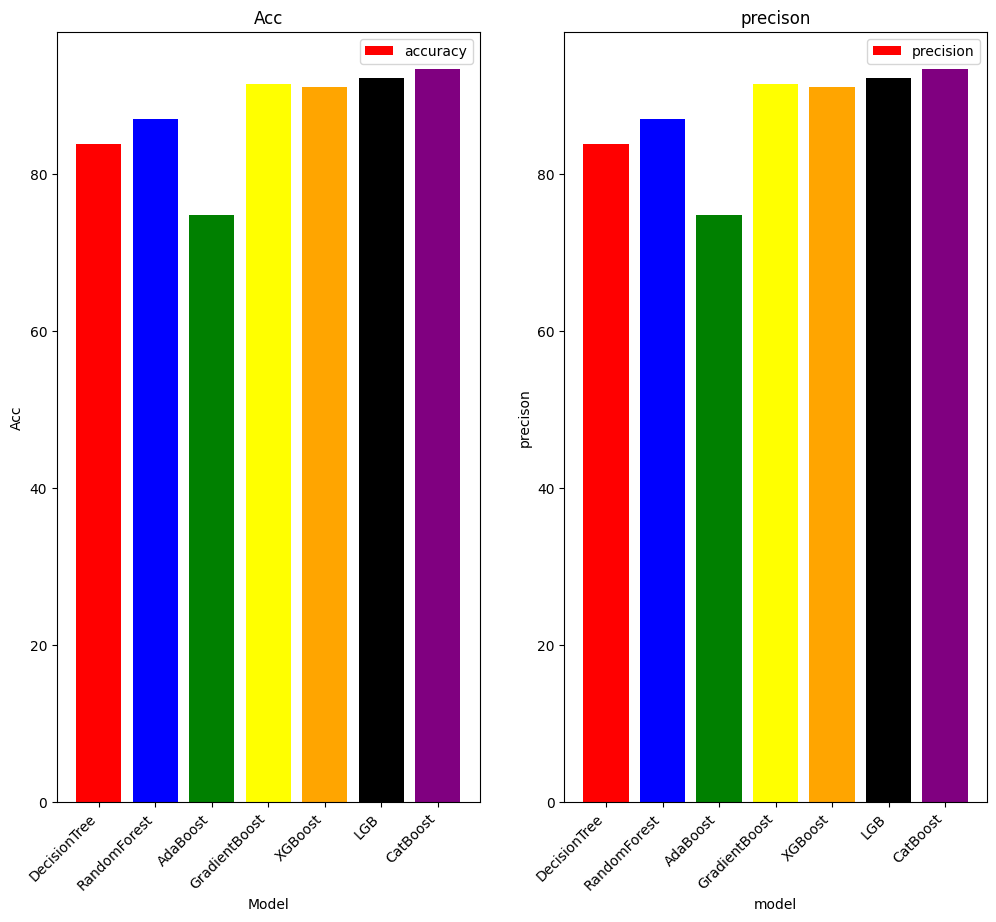

In [112]:
ModelPhone.run()